# This is a the All Sky Simulation for MWM RV Targets

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table,vstack
from targetlib import testfield_gal,testfield_fk5,testfield_ecl
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic,FK5,BarycentricTrueEcliptic
from astropy import units as u
%matplotlib inline

## History
- New in Gamma-2-yso
   - No changes with respect to Gamma-2-cad_match
- New in Gamma-2-cad_match
   - All cadence minimum = 1
   - All cadence maximum = 3000
- New in Gamma-0
    - Updated target list
         - Minimized problematic cadences
         - https://wiki.sdss.org/display/MWM/Stellar+and+Substellar+Companions (Version 6)
         - No longer need to fix cadence names

In [2]:
#Define some helper functions
def safe_replace(array, old_value, new_value, tolerance =.01):
    '''
    Replace all occurances of one float value with another
    
    Arguments:
        array: numerical numpy array with NaNs
        old_value: value to replace
        new_value: new value to put into array
    Optional:
        tolerance: What range to use in the float compare
    Returns:
        Array with corrected values
    '''   
    mask1 = np.zeros(array.shape, dtype=bool)
    np.less(array, old_value + tolerance, out=mask1, where=~np.isnan(array)) #Used to avoid warning with nan values
    mask2 = np.zeros(array.shape, dtype=bool)
    np.greater(array, old_value - tolerance, out=mask2, where=~np.isnan(array)) #Used to avoid warning with nan values
    
    array[(mask1 & mask2)] = new_value
    return(array)

## Read in Target Table
These targets include 60K BD desert targets plus RGB Stars from PEP.

In [3]:
ver = 'gamma-2-yso'
rv_tab = Table.read('workspace/target_files/RV/{}/MWM-RV-TargList-v06.fits'.format(ver))
rv_tab

RA,DEC,CADENCE,TYPE,PRIORITY,VALUE,EPOCHS,EXPPEREPOCH,QUANTA,FIELD,STARTYPE,H,TEFF,LOGG,FEH
float64,float64,bytes11,bytes2,int16,float32,int16,float32,float32,bytes19,bytes3,float32,float32,float32,float32
0.022759,61.869644,mwm_rv_9x1,rv,45,1.0,9,1.0,9.0,116+00,RG,8.029,4063.2935,1.2545027,-0.25458154
0.049987,61.237167,mwm_rv_9x1,rv,45,1.0,9,1.0,9.0,116+00,RG,10.022,4683.4907,2.368814,0.07096145
0.062859,62.493454,mwm_rv_9x4,rv,45,1.0,9,4.0,36.0,116+00,RG,11.726,4961.0977,2.8163643,-0.08966255
0.071565,61.797249,mwm_rv_9x1,rv,45,1.0,9,1.0,9.0,116+00,RG,10.673,4757.2915,2.317016,-0.29075155
0.071635,62.359013,mwm_rv_9x1,rv,45,1.0,9,1.0,9.0,116+00,RG,9.595,3976.98,0.9257126,-0.31040156
0.084866,61.894894,mwm_rv_9x4,rv,45,1.0,9,4.0,36.0,116+00,RG,12.178,4530.4346,2.0909562,-0.29063156
0.088255,61.611687,mwm_rv_9x1,rv,45,1.0,9,1.0,9.0,116+00,RG,10.18,4209.6323,1.5142746,-0.26016155
0.097458,61.695633,mwm_rv_9x4,rv,45,1.0,9,4.0,36.0,116+00,RG,11.885,4983.2695,2.5116093,-0.10587155
0.099521,61.863117,mwm_rv_9x4,rv,45,1.0,9,4.0,36.0,116+00,RG,12.115,4759.338,3.0153658,0.16794845


## Statistical Binary Sample
This is a mock sample of ~100k stars (current pass has 60k) that overlaps with BHM_AQMES_WIDE

In [4]:
rv_few_tab = Table.read('workspace/target_files/RV/{}/MWM-RV-fewEpoch-v02.fits'.format(ver))
rv_few_tab

RA,DEC,HMAG,CADENCE,TYPE,PRIORITY,VALUE
float64,float64,float64,bytes10,bytes5,int32,int32
120.043936,15.055741,10.029,mwm_rv_3x1,RVfew,59,1
120.053973,15.039465,7.085,mwm_rv_3x1,RVfew,59,1
120.714862,15.02776,10.023,mwm_rv_3x1,RVfew,59,1
120.807034,15.011419,9.666,mwm_rv_3x1,RVfew,59,1
120.874878,15.044825,10.269,mwm_rv_3x1,RVfew,59,1
121.004795,15.043066,10.563,mwm_rv_3x1,RVfew,59,1
121.08425,15.029097,10.092,mwm_rv_3x1,RVfew,59,1
121.072216,15.01315,10.78,mwm_rv_3x1,RVfew,59,1
121.296555,15.043659,9.663,mwm_rv_3x1,RVfew,59,1


/home/deleenm/Dropbox/Research/notebooks/SDSS-V SimTargets/allsky/targetlib.py:148: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bmap = Basemap(projection='moll', lon_0=180,lat_0=0)
/usr/local/lib/student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/student/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


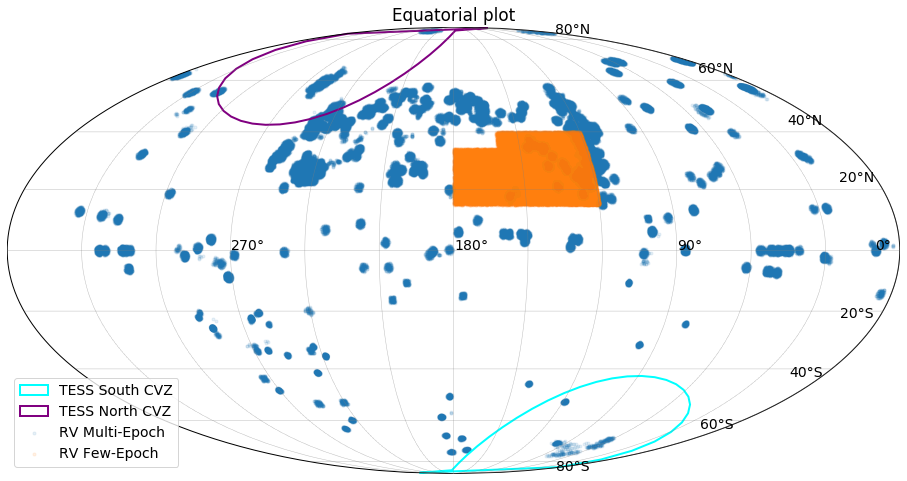

In [5]:
plt.rcParams.update({'font.size': 14})
(fig,bmap) = testfield_fk5()
#Plot RV Many-Epoch Targets
rvx,rvy = bmap(rv_tab['RA'],rv_tab['DEC'])
bmap.scatter(rvx,rvy,marker='.',label='RV Multi-Epoch',alpha=0.1)
#Plot RV Few-Epoch Targets
rvfewx,rvfewy = bmap(rv_few_tab['RA'],rv_few_tab['DEC'])
bmap.scatter(rvfewx,rvfewy,marker='.',label='RV Few-Epoch',alpha=0.1)
plt.title("Equatorial plot")
plt.legend()
plt.savefig("{}/RV.jpg".format(ver))
plt.show()

/home/deleenm/Dropbox/Research/notebooks/SDSS-V SimTargets/allsky/targetlib.py:206: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bmap = Basemap(projection='moll', lon_0=185,lat_0=0)
/usr/local/lib/student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app


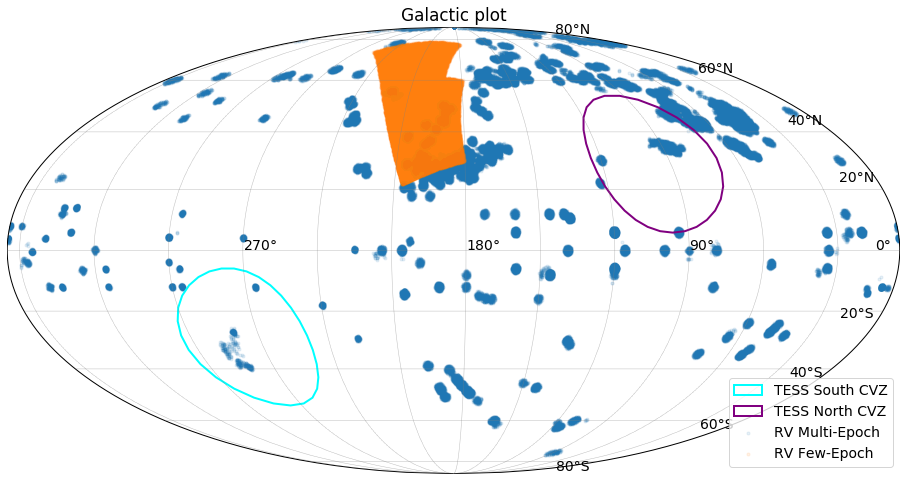

In [6]:
plt.rcParams.update({'font.size': 14})
(fig,bmap) = testfield_gal()
#Plot RV Many-Epoch Targets
rv_coord = SkyCoord(rv_tab['RA'], rv_tab['DEC'],unit=(u.deg,u.deg))
rv_coord_gal = rv_coord.transform_to(Galactic())
rvx,rvy = bmap(rv_coord_gal.l,rv_coord_gal.b)
bmap.scatter(rvx,rvy,marker='.',label='RV Multi-Epoch',alpha=0.1)
#Plot RV Few-Epoch Targets
rvfew_coord = SkyCoord(rv_few_tab['RA'], rv_few_tab['DEC'],unit=(u.deg,u.deg))
rvfew_coord_gal = rvfew_coord.transform_to(Galactic())
rvfewx,rvfewy = bmap(rvfew_coord_gal.l,rvfew_coord_gal.b)
bmap.scatter(rvfewx,rvfewy,marker='.',label='RV Few-Epoch',alpha=0.1)
plt.title("Galactic plot")
plt.legend()
plt.savefig("{}/RVgal.jpg".format(ver))
plt.show()

## Create Target Table

In [7]:
target_tab = Table()

In [8]:
target_tab['ra'] = np.concatenate([rv_tab['RA'],rv_few_tab['RA']])
target_tab['dec'] = np.concatenate([rv_tab['DEC'],rv_few_tab['DEC']])

In [9]:
target_tab['cadence'] = np.concatenate([rv_tab['CADENCE'],rv_few_tab['CADENCE']])
target_tab['type'] = np.concatenate([np.repeat('RVmany',len(rv_tab))
                                     ,np.repeat('RVfew',len(rv_few_tab))])

target_tab['priority'] = np.concatenate([np.repeat(np.array(51,dtype='int32'),len(rv_tab)),
                                        np.repeat(np.array(59,dtype='int32'),len(rv_few_tab))])
target_tab['value'] = np.repeat(np.array(1.0,dtype='float32'),len(target_tab))
target_tab

ra,dec,cadence,type,priority,value
float64,float64,bytes11,str6,int32,float32
0.022759,61.869644,mwm_rv_9x1,RVmany,51,1.0
0.049987,61.237167,mwm_rv_9x1,RVmany,51,1.0
0.062859,62.493454,mwm_rv_9x4,RVmany,51,1.0
0.071565,61.797249,mwm_rv_9x1,RVmany,51,1.0
0.071635,62.359013,mwm_rv_9x1,RVmany,51,1.0
0.084866,61.894894,mwm_rv_9x4,RVmany,51,1.0
0.088255,61.611687,mwm_rv_9x1,RVmany,51,1.0
0.097458,61.695633,mwm_rv_9x4,RVmany,51,1.0
0.099521,61.863117,mwm_rv_9x4,RVmany,51,1.0


In [10]:
target_tab.write('{}/mwm_rv_target_{}.fits'.format(ver,ver),overwrite=True)

## Create Cadence Table

In [11]:
rv_cad_tab = Table.read('workspace/target_files/RV/{}/MWM-RVcadences_v2_ideal.fits'.format(ver))
rv_cad_tab

cadence,nepochs,delta [72],softness [72],delta_min [72],delta_max [72],lunation [72],instrument [72]
bytes6,int32,float32,float32,float32,float32,float32,bytes6
rv3x1,3,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv3x2,6,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv3x4,12,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x1,6,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x2,12,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x4,24,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x1,9,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x2,18,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x4,36,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..


## Clean up the cadence names

In [12]:
cadence_tab = Table()

In [13]:
cadence_list = list(rv_cad_tab['cadence'])
cadence_list = ['mwm_'+ x for x in cadence_list]
cadence_list = [x.replace('rv','rv_') for x in cadence_list]
print(cadence_list)

['mwm_rv_3x1', 'mwm_rv_3x2', 'mwm_rv_3x4', 'mwm_rv_6x1', 'mwm_rv_6x2', 'mwm_rv_6x4', 'mwm_rv_9x1', 'mwm_rv_9x2', 'mwm_rv_9x4', 'mwm_rv_12x1', 'mwm_rv_12x2', 'mwm_rv_12x4', 'mwm_rv_15x1', 'mwm_rv_15x2', 'mwm_rv_15x4', 'mwm_rv_18x1', 'mwm_rv_18x2', 'mwm_rv_18x4']


In [14]:
cadence_tab['cadence'] = cadence_list
cadence_tab['nepochs'] = rv_cad_tab['nepochs']

In [15]:
cadence_tab['delta'] = rv_cad_tab['delta']
cadence_tab

cadence,nepochs,delta [72]
str11,int32,float32
mwm_rv_3x1,3,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan


In [16]:
#Fix issue with first number
for i in range(len(rv_cad_tab)):
    rv_cad_tab['delta_min'][i][0] = 0
print(rv_cad_tab['delta'][12])
print(rv_cad_tab['delta_min'][17])

[  0.   3.   3.  30.   3.   3.  30.   3.   3. 300.   3.   3.  30.   3.
   3.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
[  0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.
   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.
   1.   0.   0.   0.   1.   0.   0.   0. 180.   0.   0.   0.   1.   0.
   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.]


## Make all the nonzero minimums 1

In [17]:
print(rv_cad_tab['delta_min'][17])
rv_cad_tab['delta_min'][(rv_cad_tab['delta_min'] > 0)]  = 1
print(rv_cad_tab['delta_min'][17])

[  0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.
   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.
   1.   0.   0.   0.   1.   0.   0.   0. 180.   0.   0.   0.   1.   0.
   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.]
[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


/usr/local/lib/student/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [18]:
cadence_tab['delta_min'] = rv_cad_tab['delta_min']
cadence_tab

cadence,nepochs,delta [72],delta_min [72]
str11,int32,float32,float32
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan


## Make all delta_max = 3000

In [19]:
new_delta_max =  rv_cad_tab['delta_max']
new_delta_max[(rv_cad_tab['delta_max'] > 0)]  = 3000
print(rv_cad_tab['delta_max'][17])
print(new_delta_max[17])

[3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.]
[3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.
 3000.    0.    0.    0. 3000.    0.    0.    0. 3000.    0.    0.    0.]


In [20]:
#Allow for some more wiggle room with weather on back to back exposures
new_delta_max = safe_replace(rv_cad_tab['delta_max'], 0, 0.04)
#Fix issue with first number
for i in range(len(new_delta_max)):
    new_delta_max[i][0] = 0
print(new_delta_max[16])
rv_cad_tab['delta_max'] = new_delta_max

[0.e+00 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02
 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02
 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02
 3.e+03 4.e-02 3.e+03 4.e-02 3.e+03 4.e-02    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan]


In [21]:
cadence_tab['delta_max'] = rv_cad_tab['delta_max']
cadence_tab

cadence,nepochs,delta [72],delta_min [72],delta_max [72]
str11,int32,float32,float32,float32
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan,0.0 .. nan


## Let's fix lunation

In [22]:
fix_lunation = rv_cad_tab['lunation']
safe_replace(fix_lunation, 100, 1, tolerance =.01)
cadence_tab['lunation'] = fix_lunation
print(cadence_tab[(cadence_tab['cadence'] == 'mwm_rv_18x4')]['lunation'].data)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [23]:
rv_cad_tab['instrument'][(rv_cad_tab['instrument'] == b'')] = np.nan
print(rv_cad_tab['instrument'][16])

[b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan']


In [24]:
cadence_tab['instrument'] = rv_cad_tab['instrument']

In [25]:
cadence_tab

cadence,nepochs,delta [72],delta_min [72],delta_max [72],lunation [72],instrument [72]
str11,int32,float32,float32,float32,float32,bytes6
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan


In [26]:
cadence_tab.write('{}/mwm_rv_cadence_{}.fits'.format(ver,ver),overwrite=True)

In [27]:
test_tab = Table.read('{}/mwm_rv_cadence_{}.fits'.format(ver,ver))

In [28]:
for cadence in test_tab:
    print("Delta: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta']])
    print("Delta_Max: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta_max']])
    print("Delta_Min: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta_min']])

Delta:  mwm_rv_3x1 ['0.00', '3.00', '3.00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
Delta_Max:  mwm_rv_3x1 ['0.00', '3000.00', '3000.00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan',

In [29]:
print(test_tab['lunation'][16])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
